<a href="https://colab.research.google.com/github/Zahidsayyed08/sms-classifier/blob/main/spamham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import re
import joblib
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [26]:
df = pd.read_csv('/content/Spam_SMS.csv')

In [27]:
df.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
df.shape

(5574, 2)

In [29]:
df['Class'].value_counts()

,count
Class,
ham,4827
spam,747


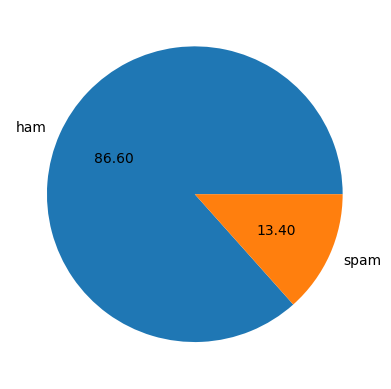

In [30]:
plt.pie(df['Class'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [31]:
df.dropna(inplace = True)

In [32]:
df.shape

(5574, 2)

In [33]:

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [34]:
def preprocess(text):
    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [35]:
df['Class'] = df['Class'].map({
    'ham':0,
    'spam':1
})

In [36]:
df_class_1 = df[df['Class']==1]
df_class_0 = df[df['Class']==0]
df_class_1_over = df_class_1.sample(4827,replace=True)
df_over = pd.concat([df_class_0,df_class_1_over],axis=0)

In [37]:
df_over['Class'].value_counts()

,count
Class,
0,4827
1,4827


In [38]:
df_over['preprocess'] = df_over['Message'].map(preprocess)

In [39]:
X_train,X_test,y_train,y_test = train_test_split(
    df_over['preprocess'],
    df_over['Class'],
    test_size=0.2,
    stratify=df_over['Class']
  )

In [41]:

classifiers = {
    "RandomForestClassifier": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "BaggingClassifier": BaggingClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier()
}

for name, classifier in classifiers.items():
    clf = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', classifier)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{name}:\n")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

RandomForestClassifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       966
           1       1.00      1.00      1.00       965

    accuracy                           1.00      1931
   macro avg       1.00      1.00      1.00      1931
weighted avg       1.00      1.00      1.00      1931

--------------------------------------------------
MultinomialNB:

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       966
           1       0.96      0.97      0.97       965

    accuracy                           0.97      1931
   macro avg       0.97      0.97      0.97      1931
weighted avg       0.97      0.97      0.97      1931

--------------------------------------------------
KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.97      0.98       965

    accuracy    

Cross-validation scores: [0.96763754 0.9592233  0.95987055 0.95854922 0.95919689]
Mean cross-validation accuracy: 0.9608955011150796

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       966
           1       1.00      0.92      0.95       965

    accuracy                           0.96      1931
   macro avg       0.96      0.96      0.96      1931
weighted avg       0.96      0.96      0.96      1931


AUC-ROC Score on Test Set: 0.9928480245443526


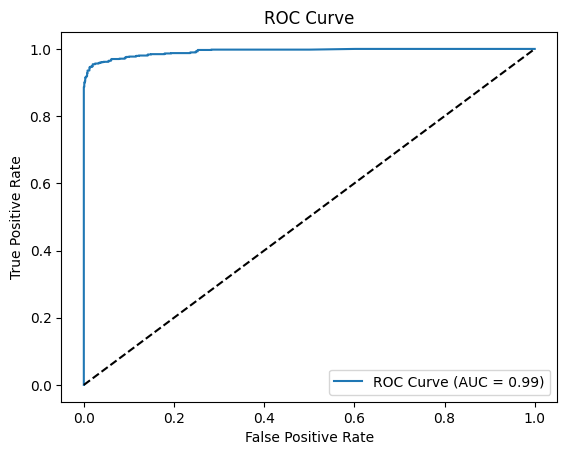

In [42]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

tfidf = TfidfVectorizer(stop_words='english', max_features=2000)  # Adjust `max_features` as needed
X_train_raw = tfidf.fit_transform(X_train)
X_test_raw = tfidf.transform(X_test)

model = RandomForestClassifier(
        n_estimators=500,
        max_depth=50,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=class_weights_dict,
        random_state=42
    )

cv_scores = cross_val_score(model, X_train_raw, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())

model.fit(X_train_raw, y_train)
y_pred = model.predict(X_test_raw)

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

y_probs = model.predict_proba(X_test_raw)[:, 1]
auc_score = roc_auc_score(y_test, y_probs)
print("\nAUC-ROC Score on Test Set:", auc_score)

fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()



In [43]:

clf = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=2000)),
    ('rfc', RandomForestClassifier(
        n_estimators=500,
        max_depth=50,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=class_weights_dict,
        random_state=42
    ))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

threshold = 0.4
y_pred_adjusted = (y_proba >= threshold).astype(int)

print("\nAdjusted Threshold Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC-AUC: {roc_auc:.3f}")


Adjusted Threshold Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.99      0.97      0.98       965

    accuracy                           0.98      1931
   macro avg       0.98      0.98      0.98      1931
weighted avg       0.98      0.98      0.98      1931


ROC-AUC: 0.996


In [44]:
tfidf = TfidfVectorizer(max_features=2000)
rfc = RandomForestClassifier(
        n_estimators=500,
        max_depth=50,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=class_weights_dict,
        random_state=42
    )

In [45]:
joblib.dump(clf.named_steps['vectorizer'], 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [46]:
joblib.dump(clf.named_steps['knn'], 'random_forest_classifier.joblib')

KeyError: 'knn'